#  Part 2: Classification automatique de biens de consommation

<u><b> ANALYSE SUPERVISEE DE TEXTE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=a425c685c2ee4e362101a182a071bc49505939548ff1dd661043c41d57136adf
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [74]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_val_predict
from sklearn.metrics import classification_report
from gensim.models.word2vec import Word2Vec
import gensim.downloader
from sentence_transformers import SentenceTransformer


# Nettoyage des données

In [7]:
data_ = r'/content/drive/MyDrive/DATA SCIENTIST/P6/df_clean.csv'
df_ = pd.read_csv(data_)


In [ ]:
df_.head()


,uniq_id,product_name,categorie,description,image,cat_num,clean_description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,4,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,0,cotton bath towel bath towel yellow bath towel...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,0,eurospa cotton terri face towel small inch gsm...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,4,santosh royal fashion cotton print king doubl ...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,4,jaipur print cotton floral king doubl bedsheet...


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')


## Construction des bases d’entraînement et de test

On va scinder notre jeu de données pour créer un jeu de données d'entrainement et un jeu de test (20 %) avant toute analyse . Cela permettra d’évaluer nos différents modèles toute à la fin de manière très rigoureuse, puisque ces données n’auront jamais utilisées pendant l’entraînement.



In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_['clean_description'].values,
                                                    df_['cat_num'].values,
                                                    test_size=0.15,
                                                    random_state=1234,
                                                    stratify = df_.categorie)


Aperçu du premier élément de X_train :

In [ ]:
X_train[0]


'printland ceram mug printland coffe mug ador fantast coffe mug enjoy morn coffe tea huge mug ceram perfect kitchen wardrob stylish eleg serv tea coffe mug casual togeth home also perfect gift present love printland coffe mug ador fantast coffe mug enjoy morn coffe tea huge mug ceram perfect kitchen wardrob stylish eleg serv tea coffe mug casual togeth home also perfect gift present love'

On peut aussi vérifier qu’on est capable de retrouver la correspondance entre nos catégories initiales avec la méthode inverse_transform

In [9]:
# creation d'un variable numerique pour la categorie
lbe = LabelEncoder()
df_['cat_num'] = lbe.fit_transform(df_['categorie'])

# vérification
lbe.inverse_transform([0,1,2,3,4,5,6])

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [10]:
print(y_train[0], lbe.inverse_transform([y_train[0]])[0])


5 Kitchen & Dining


# Statistiques exploratoires

Rappel un graphique déjà produit précédemment pour voir la répartition du corpus entre les catégories.

<Axes: >

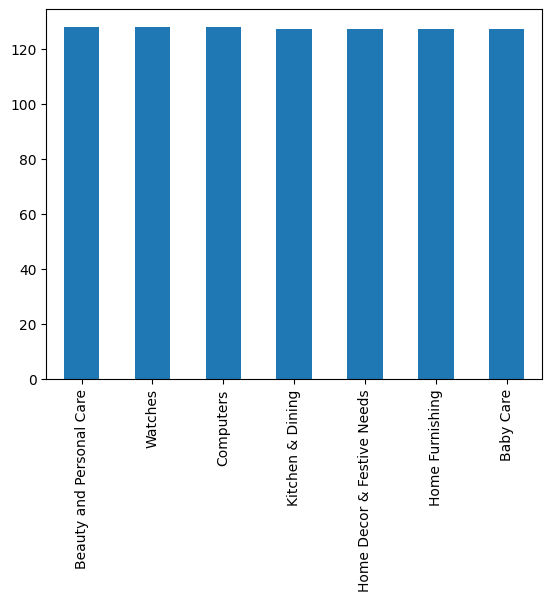

In [ ]:
fig = pd.Series(lbe.inverse_transform(y_train)).value_counts().plot(kind='bar')
fig


Les catégories sont parfaitement équilibrées

## Prédiction sur le set d’entraînement

Nous allons à présent comparer plusieurs modèles de vectorisation c-à-d de transformation du texte en objets numériques pour que l’information contenue soit exploitable dans un modèle de classification.

### Démarche

 Comme nous nous intéressons plus à l’effet de la vectorisation qu’à la tâche de classification en elle-même, nous allons utiliser un algorithme de classification simple (un SVM linéaire), avec des paramètres non fine-tunés (c’est-à-dire des paramètres pas nécessairement choisis pour être les meilleurs de tous).

In [11]:
clf = LinearSVC(max_iter=10000, C=0.1)


Ce modèle est connu pour être très performant sur les tâches de classification de texte, et nous fournira donc un bon modèle de référence (baseline). Cela nous permettra également de comparer de manière objective l’impact des méthodes de vectorisation sur la performance finale.

Pour les deux premières méthodes de vectorisation (basées sur des fréquences et fréquences relatives des mots), on va simplement normaliser les données d’entrée, ce qui va permettre au SVM de converger plus rapidement, ces modèles étant sensibles aux différences d’échelle dans les données.

On va également fine-tuner via grid-search certains hyperparamètres liés à ces méthodes de vectorisation :

    on teste différents ranges de n-grams (unigrammes et unigrammes + bigrammes)
    on teste avec et sans stop-words

Afin d’éviter le surapprentissage, on va évaluer les différents modèles avec une validation croisée cv=5.

On récupère à la fin le meilleur modèle selon la métrique accuracy.

## Pipeline de prédiction

On va utiliser un pipeline pour gérer de manière cohérente nos différentes transformations

Pour se faciliter la vie, on définit une fonction fit_vectorizers qui intègre dans un pipeline générique une méthode d’estimation  et fait de la validation croisée en cherchant le meilleur modèle ( avec unigrammes/bigrammes)

In [63]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    #print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [64]:
def fit_vectorizers(vectorizer):
    pipeline = Pipeline(
    [
        ("vect", vectorizer()),
        ("scaling", StandardScaler(with_mean=False)),
        ("clf", clf),
    ]
    )

    parameters = {
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams , bigrams
    }

    grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy',
                               cv=5, n_jobs=5, verbose=1)
    grid_search.fit(X_train, y_train)




    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


    print(f"CV scores {grid_search.cv_results_['mean_test_score']}")
    print(f"Mean accuracy {np.mean(grid_search.cv_results_['mean_test_score'])}")

    y_pred = grid_search.best_estimator_.predict(X_test)

    cls_labels_transform = conf_mat_transform(y_test, grid_search.best_estimator_.predict(X_test))
    print(metrics.classification_report(y_test, cls_labels_transform))
    conf_mat = confusion_matrix(y_test, cls_labels_transform)
    df_cm = pd.DataFrame(conf_mat, index = [label for label in df_['categorie'].unique()],
                  columns = [i for i in range(7)])
    plt.figure(figsize = (16,6))
    sns.heatmap(df_cm, annot=True, cmap="Blues")


    return grid_search


# Approche bag-of-words

On commence par une approche “bag-of-words”, i.e. qui revient simplement à représenter chaque document par un vecteur qui compte le nombre d’apparitions de chaque mot du vocabulaire dans le document.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
	vect__ngram_range: (1, 2)
CV scores [0.89799134 0.91368401]
Mean accuracy 0.9058376749733223
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.91      0.91      0.91        22
           2       0.92      1.00      0.96        22
           3       0.91      0.87      0.89        23
           4       1.00      0.91      0.95        23
           5       1.00      0.91      0.95        23
           6       1.00      1.00      1.00        22

    accuracy                           0.93       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.93      0.93      0.93       158



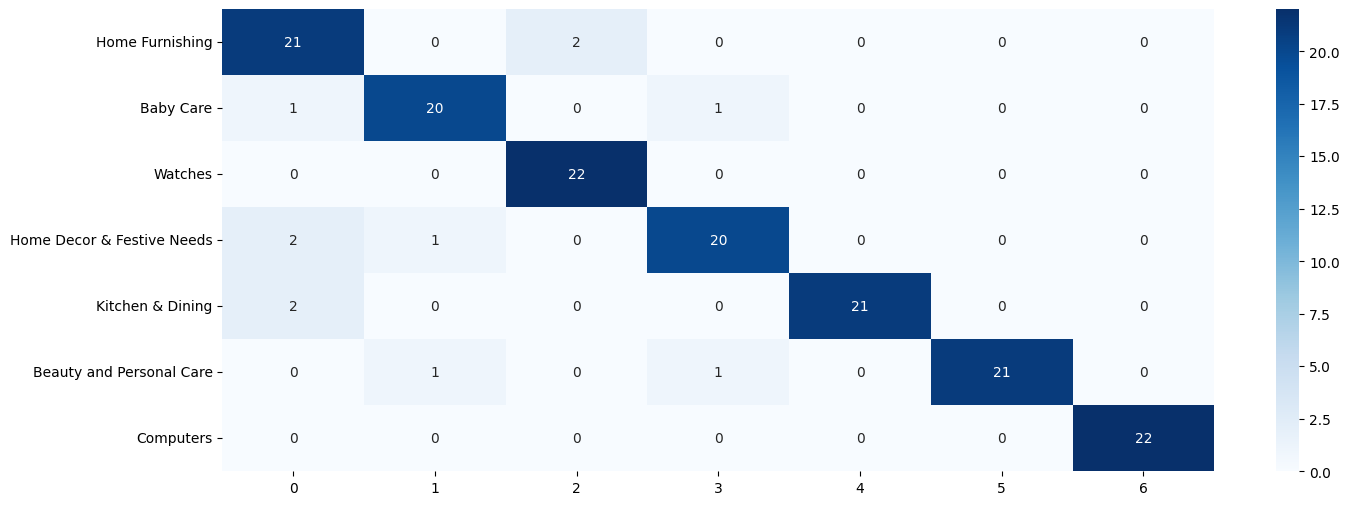

In [65]:
cv_bow = fit_vectorizers(CountVectorizer)


# TF-IDF

On passe ensuite au TF-IDF, qui permet de tenir compte des fréquences relatives des mots.

Ainsi, pour un mot donné, on va multiplier la fréquence d’apparition du mot dans le document  par un terme qui pénalise une fréquence élevée du mot dans le corpus.

La vectorisation TF-IDF permet donc de limiter l’influence des stop-words et donc de donner plus de poids aux mots les plus saillants d’un document. On observe clairement que la performance de classification est bien supérieure, ce qui montre la pertinence de cette technique.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
	vect__ngram_range: (1, 2)
CV scores [0.8990961 0.9304689]
Mean accuracy 0.9147824995292198
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.95      0.91      0.93        22
           2       0.92      1.00      0.96        22
           3       0.91      0.91      0.91        23
           4       0.95      0.91      0.93        23
           5       0.96      0.96      0.96        23
           6       1.00      1.00      1.00        22

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158



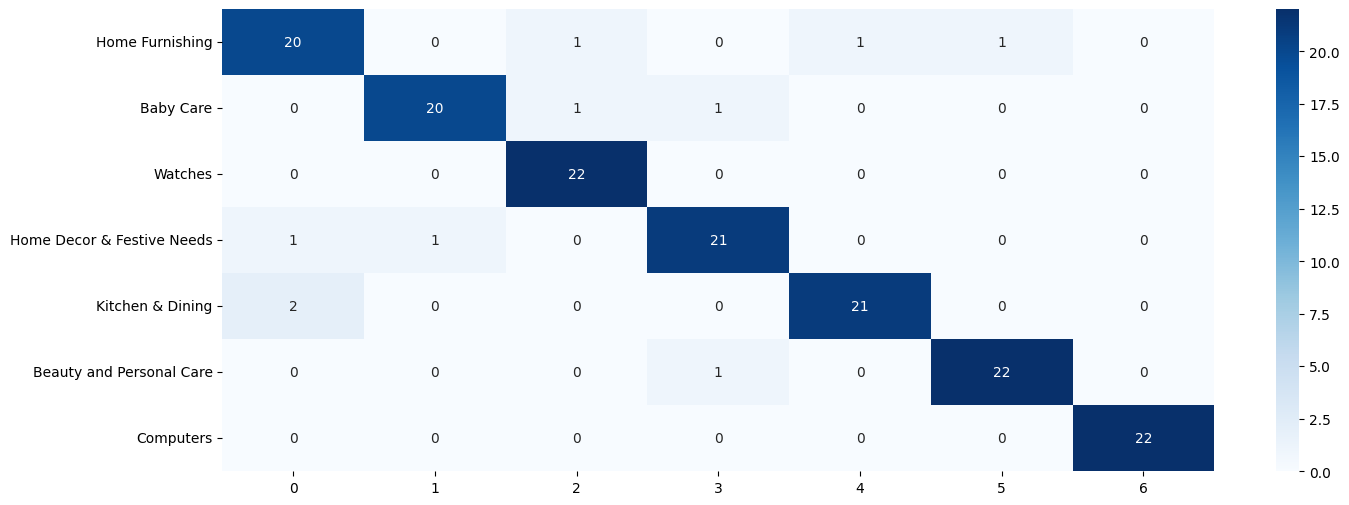

In [89]:
cv_tfidf = fit_vectorizers(TfidfVectorizer)


# Word2vec avec averaging

On peut aussi utiliser les techniques de vectorisation basées sur les embeddings de mots pour entrainer notre modèle : Word2Vec.

Au lieu de représenter les documents par des vecteurs sparse de très grande dimension (la taille du vocabulaire) comme on l’a fait jusqu’à présent, on  les représente par des vecteurs dense (continus) de dimension réduite (en général, autour de 100-300).

Chacune de ces dimensions va représenter un facteur latent, c’est à dire une variable inobservée, de la même manière que les composantes principales produites par une ACP.



In [68]:
X_train_tokens = [text.split() for text in X_train]
w2v_model = Word2Vec(X_train_tokens, vector_size=200, window=5,
                     min_count=1, workers=5)


In [ ]:
w2v_model.wv.most_similar("watch")


[('men', 0.9996388554573059),
 ('women', 0.9992740154266357),
 ('analog', 0.9992343187332153),
 ('maxima', 0.9983163475990295),
 ('digit', 0.9976845979690552),
 ('discount', 0.9974177479743958),
 ('perucci', 0.9970622062683105),
 ('dial', 0.9964251518249512),
 ('onlin', 0.9963232278823853),
 ('com', 0.9962427616119385)]



C’est lié à la taille très restreinte du corpus sur lequel on entraîne le modèle, qui ne permet pas de réaliser des associations toujours pertinentes.

L’embedding (la représentation vectorielle) de chaque document correspond à la moyenne des word-embeddings des mots qui le composent :

In [76]:
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

def fit_w2v_avg(w2v_vectors):
    X_train_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])

    scores = cross_val_score(clf, X_train_vectors, y_train,
                         cv=5, scoring='accuracy', n_jobs=5)


    print(f"CV scores {scores}")
    print(f"Mean accuracy {np.mean(scores)}")

    y_pred = cross_val_predict(clf, X_train_vectors, y_train, cv=5)
    conf_mat = confusion_matrix(y_train, y_pred)
    #print(conf_mat)
    df_cm = pd.DataFrame(conf_mat, index = [label for label in df_['categorie'].unique()],
                  columns = [i for i in range(7)])
    plt.figure(figsize = (16,6))
    sns.heatmap(df_cm, annot=True, cmap="Blues")




    return scores


CV scores [0.47486034 0.44692737 0.47752809 0.50561798 0.46067416]
Mean accuracy 0.47312158684326155


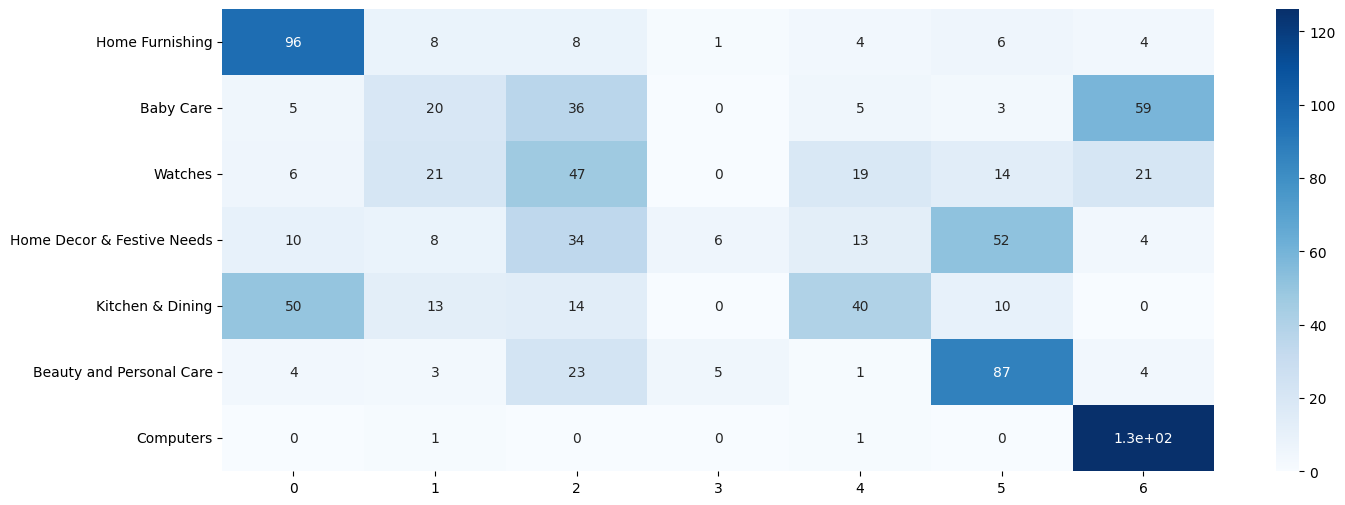

In [77]:
cv_w2vec = fit_w2v_avg(w2v_model.wv)


La performance chute fortement en cause la petite taille du corpus.

# Word2vec pré-entraîné + averaging

le corpus est de taille restreinte, il est difficile d’entraîner son propre modèle word2vec et d'obtenir des résultats probants.

Dans ce cas il vaut mieux faire du transfert learning en utilisant des modèles pré-entraînés sur de très gros corpus  .On peut bénéficier de la performance du modèle qui a été entraîné sur une autre tâche ou bien sur un autre corpus.

On va utiliser Glove pour Global Vectors for Word Representation

    GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

  

On peut le charger directement grâce à l’instruction suivante :

In [ ]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')


[==================================================] 100.0% 252.1/252.1MB downloaded


Par exemple, la représentation vectorielle de watch est l’objet multidimensionnel suivant :

In [ ]:
glove_model['watch']


array([ 8.6892e-01,  2.3822e-01, -6.1385e-01, -5.7118e-01, -4.7405e-01,
       -3.7876e-03, -3.6406e-01,  2.7454e-01,  9.1425e-02,  1.9755e-01,
        9.8624e-02,  2.3183e-01,  3.5018e-01, -3.0006e-01, -2.9300e-02,
       -1.9190e-01, -2.2812e-01,  6.2873e-01, -2.7343e-01,  2.0234e-01,
        7.1970e-02,  1.6687e+00, -2.9206e-02, -3.9194e-01, -1.2168e-01,
       -3.6784e-01,  1.5848e-01,  3.0106e-01, -2.9061e-01, -2.7422e-01,
        1.0633e-01,  1.9232e-01,  1.6958e-01,  3.9497e-02, -1.8672e-01,
       -1.0647e-01, -2.4056e-01, -9.1826e-02,  4.3249e-01, -6.5210e-02,
        1.8072e-01,  3.2750e-01,  6.3738e-01,  6.5817e-01, -2.5951e-01,
        6.7182e-01,  9.6189e-01, -6.0682e-01,  7.4749e-02,  7.5849e-02,
        2.3927e-01,  9.8000e-02, -3.2888e-01, -5.4973e-01, -2.4730e-01,
        1.2131e-01,  2.4332e-01, -4.9811e-01, -5.1394e-02,  1.8629e-01,
        1.0579e-01, -1.4824e-02,  1.9960e-01,  9.4391e-02, -1.6904e-01,
        5.2249e-02,  4.4394e-02, -3.5623e-02,  2.4420e-01, -2.19

Comme elle est peu compréhensible sous cette forme, on peut rechercher les termes les plus similaires.

In [ ]:
glove_model.most_similar('watch')


[('watching', 0.7856484651565552),
 ('watched', 0.6797265410423279),
 ('watches', 0.6186408400535583),
 ('everyone', 0.6093867421150208),
 ("'ll", 0.608327329158783),
 ('you', 0.6075742840766907),
 ('tell', 0.6048123240470886),
 ('sure', 0.5997323393821716),
 ('see', 0.5972888469696045),
 ('know', 0.5910592675209045)]

Faisons notre apprentissage par transfert :

CV scores [0.93296089 0.87150838 0.87640449 0.87078652 0.87078652]
Mean accuracy 0.884489360366581


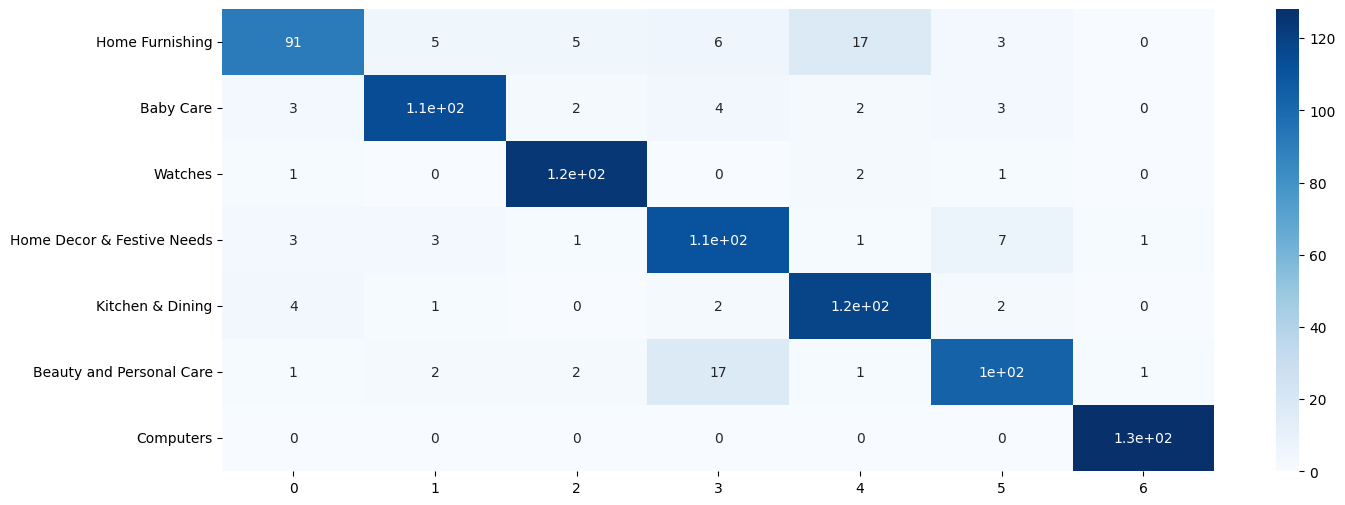

In [81]:
cv_w2vec_transfert = fit_w2v_avg(glove_model)


La performance remonte substantiellement. Cela étant, on ne parvient pas à faire mieux que les approches basiques, on arrive à peine aux performances de la vectorisation par comptage.

In [87]:
perfs = pd.DataFrame(
    [np.mean(cv_bow.cv_results_['mean_test_score']),
     np.mean(cv_tfidf.cv_results_['mean_test_score']),
    np.mean(cv_w2vec),
    np.mean(cv_w2vec_transfert)],
    index = ['Bag-of-Words','TF-IDF', 'Word2Vec non pré-entraîné', 'Word2Vec pré-entraîné'],
    columns = ["Mean accuracy"]
).sort_values("Mean accuracy",ascending = False)
perfs


,Mean accuracy
TF-IDF,0.914782
Bag-of-Words,0.905838
Word2Vec pré-entraîné,0.884489
Word2Vec non pré-entraîné,0.473122


Les performances limitées du modèle Word2Vec sont cette fois certainement dues à la manière dont les word-embeddings sont exploités : ils sont moyennés pour décrire chaque document.

Cela a plusieurs limites :

    on ne tient pas compte de l’ordre et donc du contexte des mots
    lorsque les documents sont longs, la moyennisation peut créer des représentations bruitées.


# Contextual embeddings

Les embeddings contextuels visent à pallier les limites des embeddings traditionnels évoquées précédemment.

Cette fois, les mots n’ont plus de représentation vectorielle fixe, celle-ci est calculée dynamiquement en fonction des mots du voisinage, et ainsi de suite. Cela permet de tenir compte de la structure des phrases et de tenir compte du fait que le sens d’un mot est fortement dépendant des mots qui l’entourent.
Ces embeddings sont produits par des architectures très complexes, de type Transformer (BERT, etc.).

In [83]:
model = SentenceTransformer('all-mpnet-base-v2')


In [84]:
X_train_vectors = model.encode(X_train)


CV scores [0.94972067 0.93296089 0.90449438 0.92134831 0.89325843]
Mean accuracy 0.9203565375682631


<Axes: >

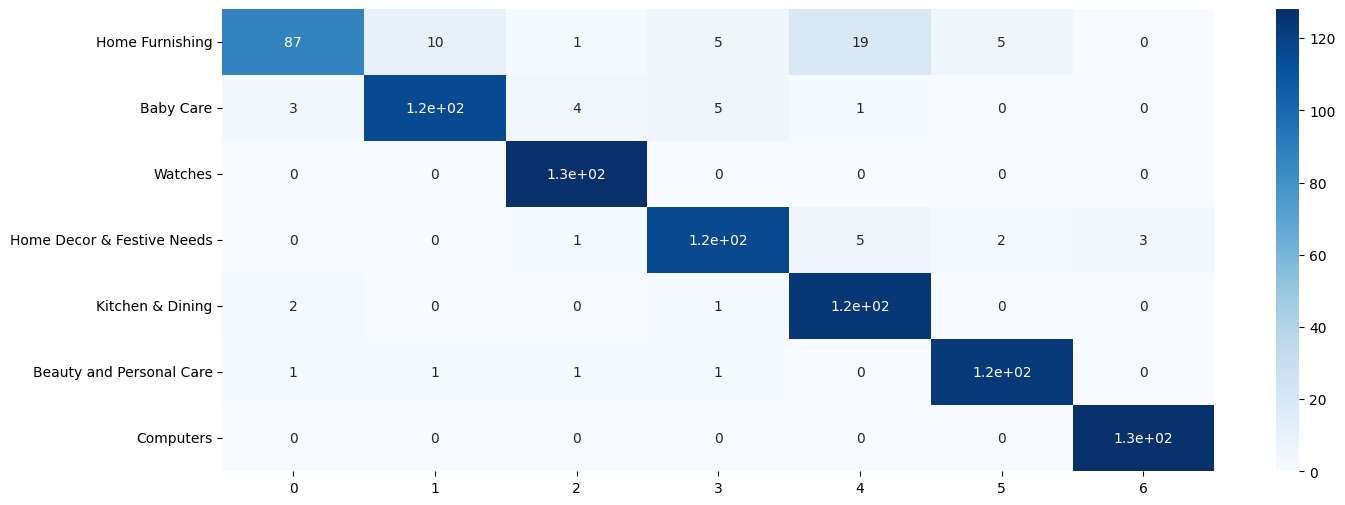

In [85]:
scores = cross_val_score(clf, X_train_vectors, y_train,
                         cv=5, scoring='accuracy', n_jobs=5)

print(f"CV scores {scores}")
print(f"Mean accuracy {np.mean(scores)}")

y_pred = cross_val_predict(clf, X_train_vectors, y_train, cv=5)
conf_mat = confusion_matrix(y_train, y_pred)
#print(conf_mat)
df_cm = pd.DataFrame(conf_mat, index = [label for label in df_['categorie'].unique()],
                  columns = [i for i in range(7)])
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")


In [88]:
perfs = pd.concat(
  [perfs,
  pd.DataFrame(
    [np.mean(scores)],
    index = ['Contextual Embedding'],
    columns = ["Mean accuracy"])]
).sort_values("Mean accuracy",ascending = False)
perfs


,Mean accuracy
Contextual Embedding,0.920357
TF-IDF,0.914782
Bag-of-Words,0.905838
Word2Vec pré-entraîné,0.884489
Word2Vec non pré-entraîné,0.473122


In [ ]:
perfs.to_csv('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P6\\performances.csv',index=True)

Constatations: le modèle Avec Contextual Embedding obtient le meilleur score devant la vectorisation TF-IDF. On voit donc l’importance de tenir compte du contexte.



<u><b>  ANALYSE DE TEXTE NON SUPERVISEE

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
import re
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\serge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\serge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\serge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Bag of word - Tf-idf

In [ ]:

# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize,wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words



import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.decomposition import PCA, TruncatedSVD
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


In [ ]:
#data_ = r'/content/drive/MyDrive/DATA SCIENTIST/P6/df_clean.csv'

data_ = r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\df_clean.csv'
df_ = pd.read_csv(data_)

In [ ]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text



In [ ]:
df_['description_bow'] = df_['description'].apply(lambda x : transform_bow_fct(x))
df_['description_bow_lem'] = df_['description'].apply(lambda x : transform_bow_lem_fct(x))
df_['description_dl'] = df_['description'].apply(lambda x : transform_dl_fct(x))


In [ ]:
df_.sample(1)

,uniq_id,product_name,categorie,description,image,cat_num,clean_description,description_bow,description_bow_lem,description_dl
872,7b1dd192151777c246a1c4e1fe0ddb4c,Trident Cotton Set of Towels,Home Furnishing,"Trident Cotton Set of Towels (2 Bath Towels, B...",7b1dd192151777c246a1c4e1fe0ddb4c.jpg,4,cotton towel bath towel bath towel skin refres...,trident cotton set towels bath towels blue pin...,trident cotton set towel bath towel blue pink ...,"trident cotton set of towels ( 2 bath towels ,..."


In [ ]:
l_cat = list(set(df_["categorie"]))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df_.iloc[i]["categorie"])) for i in range(len(df_))]

catégories :  ['Baby Care', 'Computers', 'Home Furnishing', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Watches', 'Beauty and Personal Care']


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

df_['length_bow'] = df_['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df_['length_bow'].max())
df_['length_dl'] = df_['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df_['length_dl'].max())


max length bow :  379
max length dl :  632


In [ ]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre les vraies catégories et les n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(16,8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégorie réelle')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par cluster')

    plt.show()
    print("ARI : ", ARI)


## Création du bag of words ( vectorisation de description_bow_lem)

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'description_bow_lem'
cv_fit = cvect.fit(df_[feat])
ctf_fit = ctf.fit(df_[feat])

# matrices creuses numpy
cv_transform = cvect.transform(df_[feat])
ctf_transform = ctf.transform(df_[feat])

##   calcul de ARI

CountVectorizer : 
-----------------
ARI :  0.4174 time :  16.0



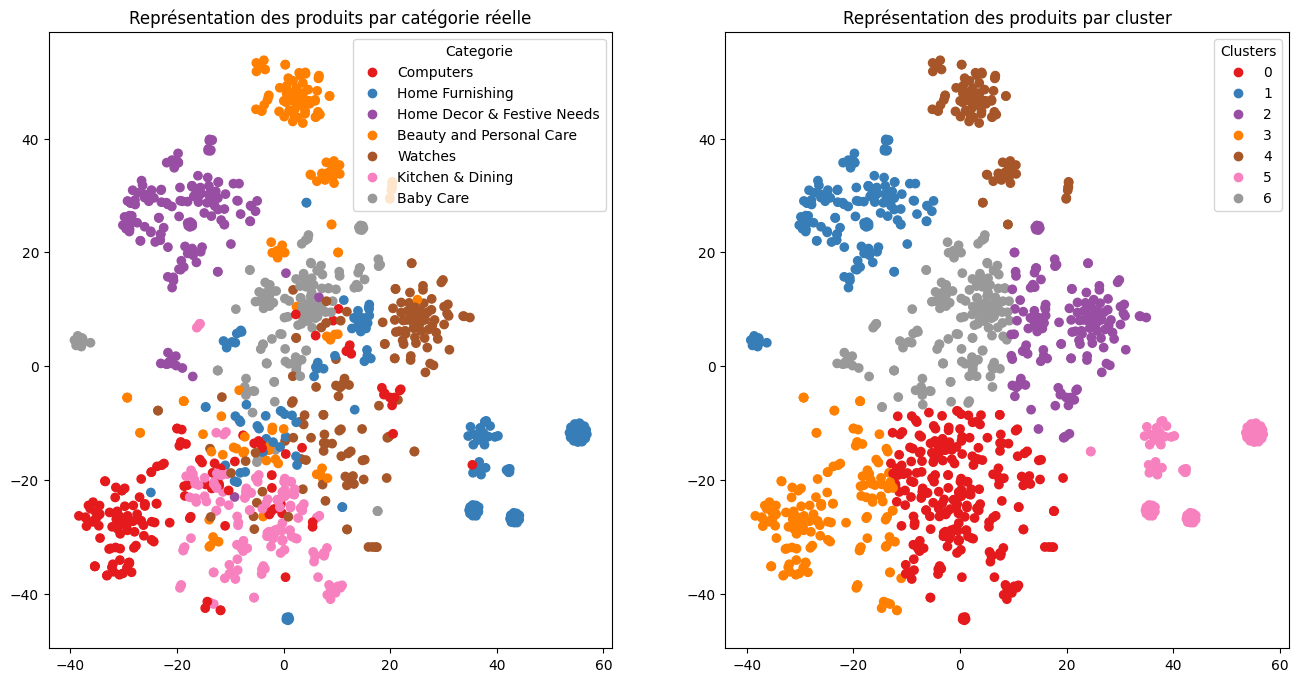

ARI :  0.4174

Tf-idf : 
--------
ARI :  0.451 time :  15.0


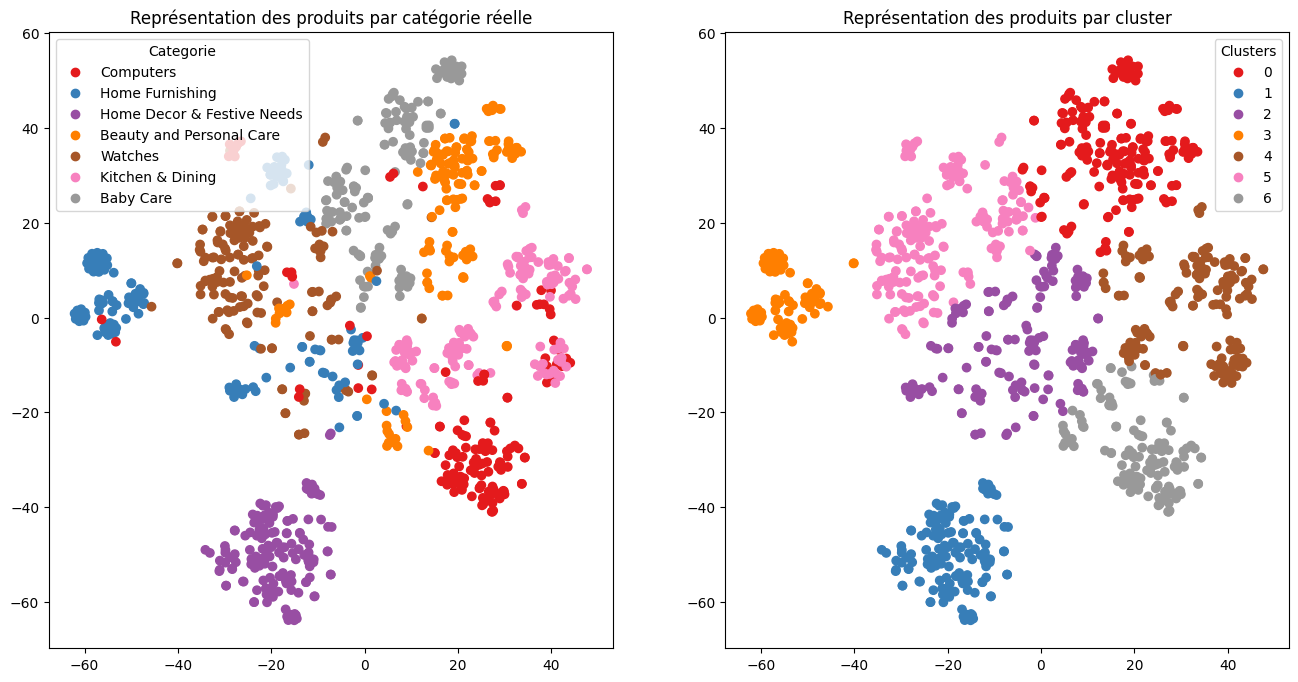

ARI :  0.451


In [ ]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## représentation graphique

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec avec sentence_bow_lem

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df_['description_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

## Exécution du modèle

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [ ]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2163 time :  14.0


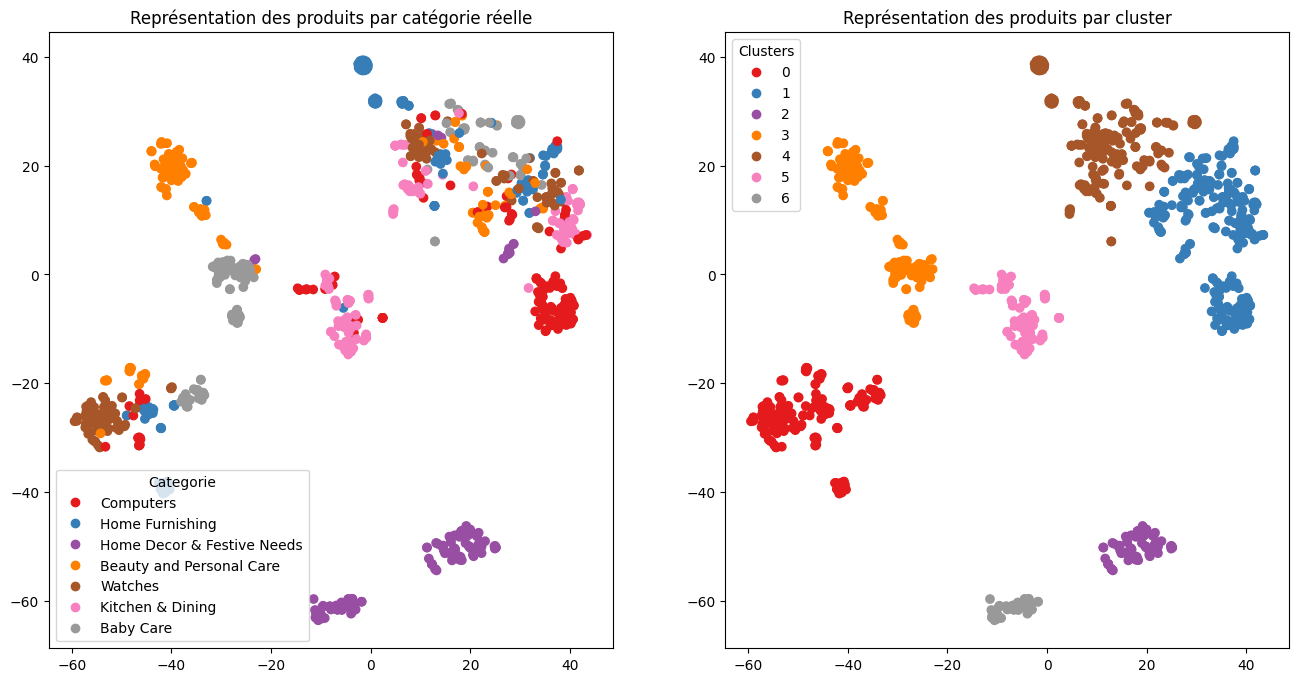

ARI :  0.2163


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.13.0
2.13.0
Num GPUs Available:  0
False


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

KeyboardInterrupt: 

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = df_['description_bow_lem'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4395 time :  22.0


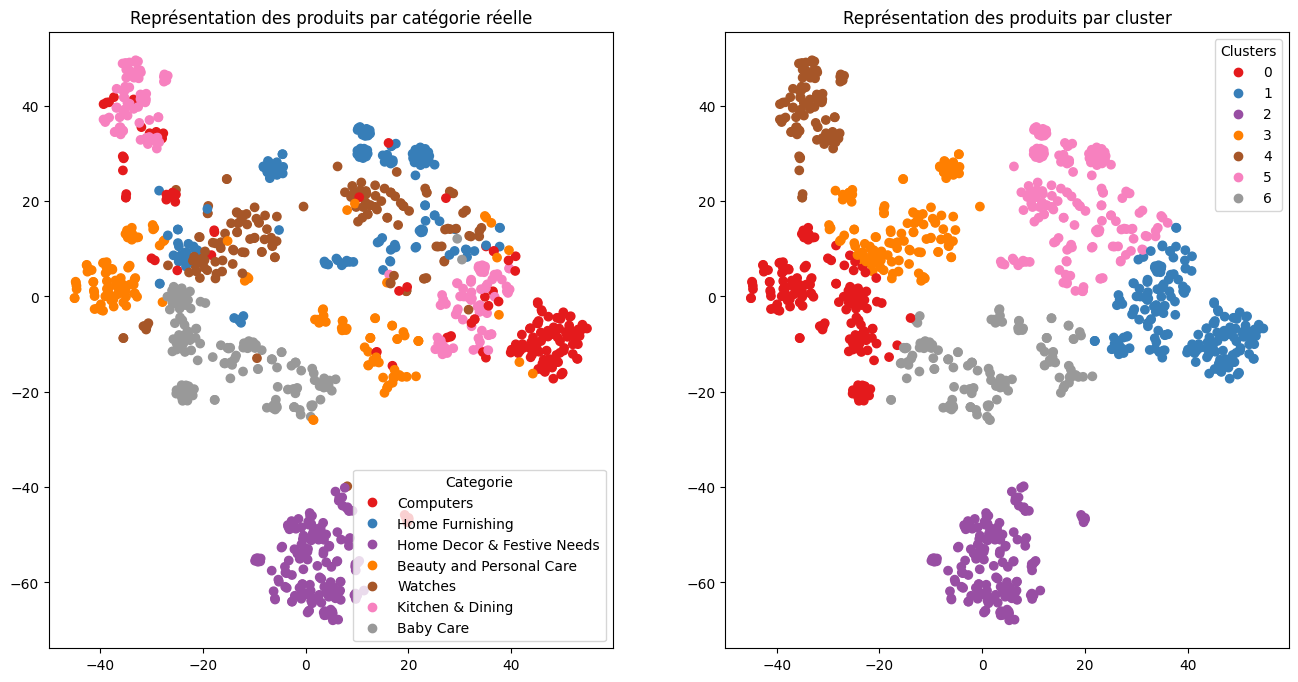

ARI :  0.4395


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_['description_bow_lem'].to_list()

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 44ms/step
temps traitement :  26.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3452 time :  14.0


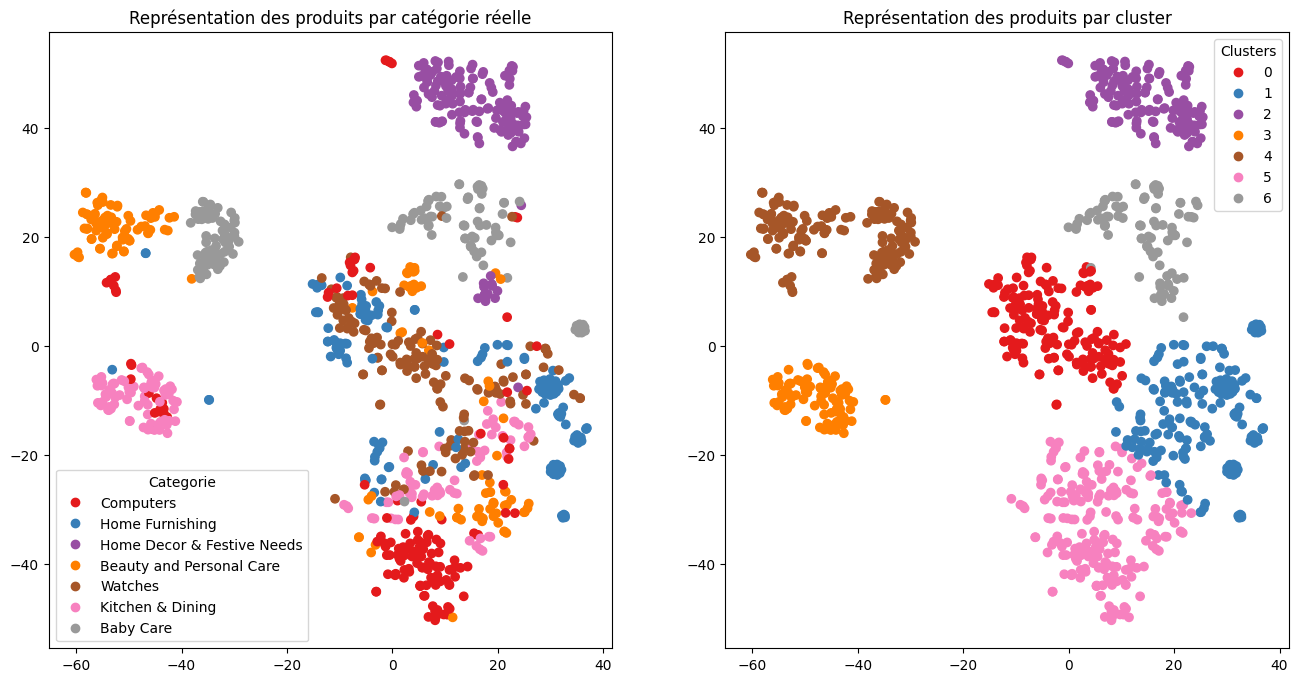

ARI :  0.3452


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [ ]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
#model_type ="gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
model = TFAutoModel.from_pretrained(model_type)
sentences = df_['description_bow_lem'].to_list()

In [ ]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 25ms/step
temps traitement :  24.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2651 time :  14.0


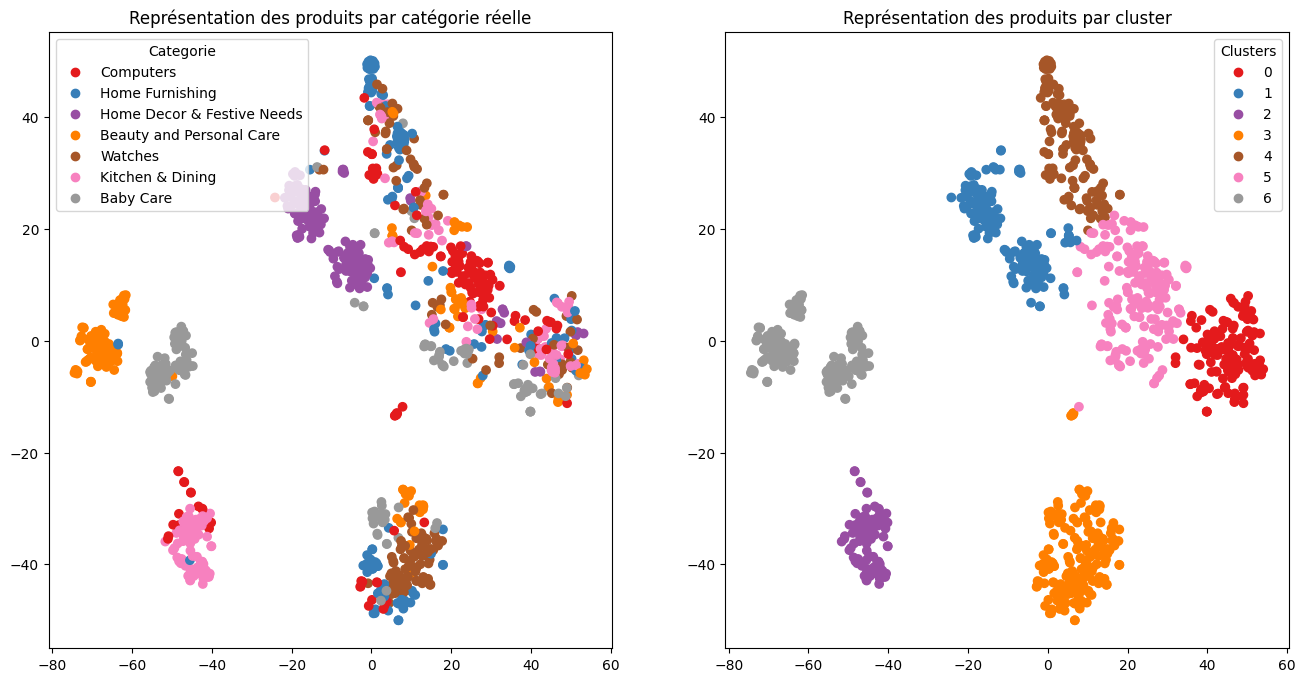

ARI :  0.2651


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [ ]:
#pip install -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.5 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
sentences = df_['description_bow_lem'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  29.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3436 time :  52.0


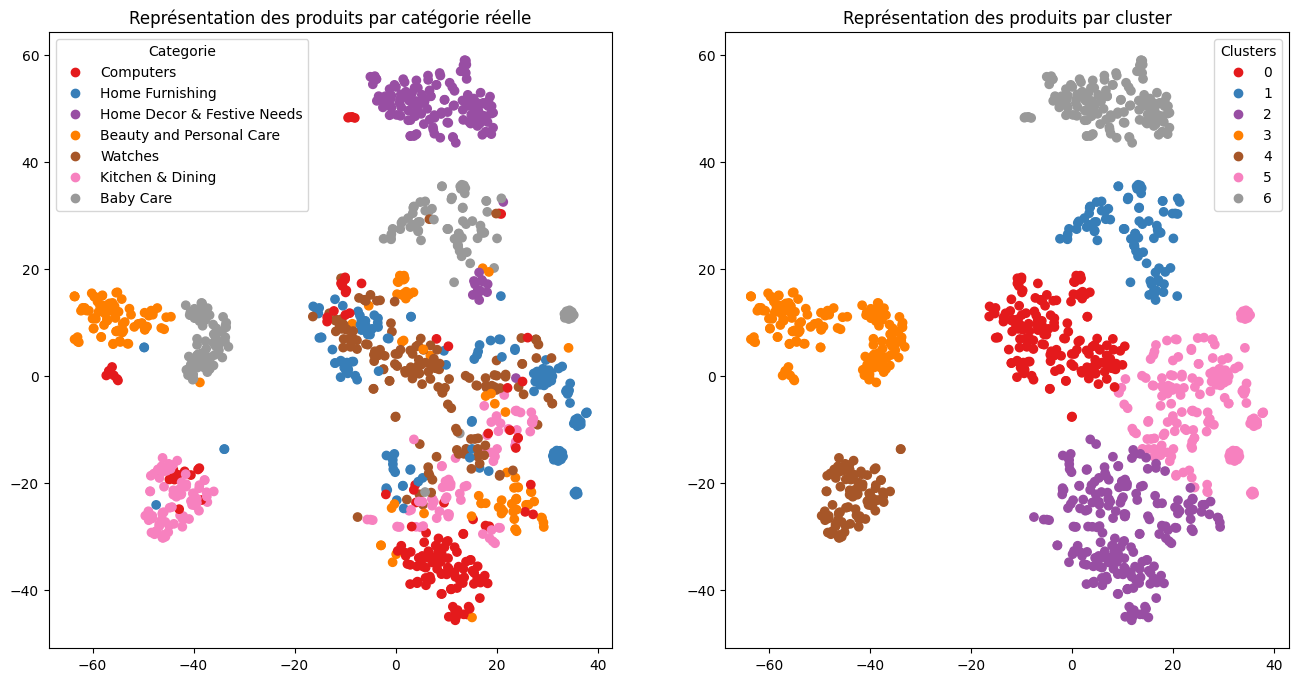

ARI :  0.3436


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = df_['description_bow_lem'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.426 time :  14.0


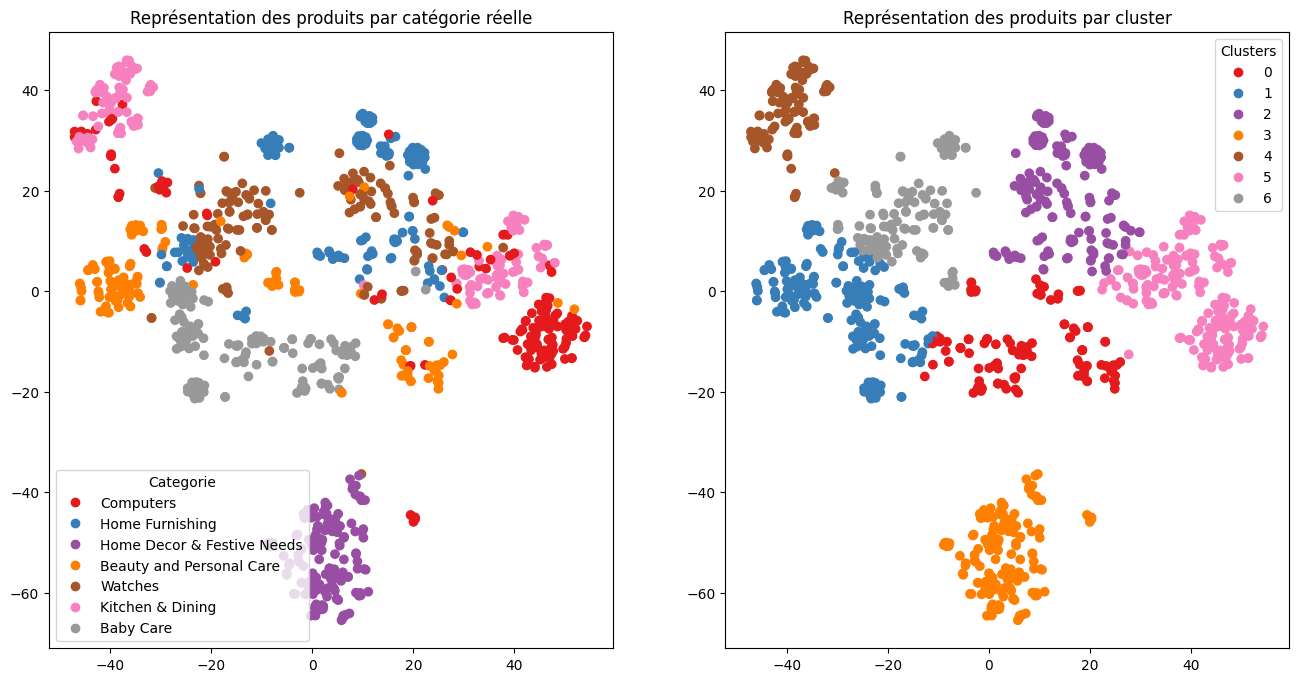

ARI :  0.426


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)